<a id='sec_Notebooks_Entrelazamiento'></a> 
# Entrelazamiento


$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\mathbb H}} $
$ \newcommand{\boldn}{{\bf n}} $
$ \newcommand{\tr}{{\rm tr}}$

- **[1 - La desigualdad CSCH](#sec_Notebooks_Entrelazamiento_1)**
- **[2 - Experimento GHZ](#sec_Notebooks_Entrelazamiento_2)**
- **[3 - Protocolo de teleportación](#sec_Notebooks_Entrelazamiento_3)**

In [1]:
# Importamos las librerías y clases necesarias
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Import para visualización
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

In [2]:
# Importamos los simuladores. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

Las siguientes funciones las definimos en el notebook [04-Medidad_II](../04-Medidas_II/04-Medidas_II.ipynb)

In [3]:
def probs_amps(cuentas): # frecuencias_dict es un diccionario con la estadística de resultados
    """
    Toma la cuentas (salida de results.get_counts()) y devuelve
    
        - Las distribuciones de probabilidades, es decir, 
          el número de cuentas de cada caso dividido entre 
          el total de cuentas.
        
        - Las amplitudes, es decir, las raices cruadradas de 
          las probabilidades
    
    Ambas las devuelve como diccionarios al igual que la entrada.       

    """
    prob_dict=cuentas.copy() # vamos a modificar el diccionario "cuentas" con las probabilidades 
    amp_dict=cuentas.copy()  # y las amplitudes
    keys = list(cuentas.keys())
    values = list(cuentas.values())
    
    N=sum(values)
    probabilidades = [v/N for v in values] # lista de frecuencias relativas
 
    for i in range(len(keys)):
        prob_dict[keys[i]]= probabilidades[i]
        amp_dict[keys[i]] = np.sqrt(probabilidades[i]) #las amplitudes, sólo en valor absoluto, las fases no son accesibles
    
    return  prob_dict, amp_dict



def val_esp_sigma(cuentas):
    probs, amps = probs_amps(cuentas)
#    print(probs)

    media = 0
    varianza = 0

    for bitstring,  prob  in probs.items():
        media += (-1)**(sum([int(bit) for bit in bitstring])) * prob 

    for bitstring,  prob  in probs.items():
        varianza += ((-1)**(sum([int(bit) for bit in bitstring]))-media)**2 * prob 
    
    sigma = np.round(np.sqrt(varianza),5)
    
    return media, sigma

def add_Pauli_measurement(circuit,paulistring):
    
    assert(circuit.num_qubits==len(paulistring))
    
    len_string = len(paulistring)
    
    for i in range(len(paulistring)):
    #for i,basis in enumerate(paulistring)):
        if  paulistring[len_string -1 - i] == 'X':
            circuit.h(i)    
            circuit.measure(i, i)
        elif paulistring[len(paulistring) -1 - i] == 'Z':
            circuit.measure(i, i)
            pass    
        elif paulistring[len(paulistring) -1 - i] == 'Y':
            circuit.sdg(i)
            circuit.h(i)
            circuit.measure(i, i)
    return circuit

<a id='sec_Notebooks_Entrelazamiento_1'></a>
##  La desigualdad CSCH   

Vamos a verificar que $R$ puede ser mayor que 2 en Mecánica cuantica:

$$
R = | \cos\theta_{AB}  + \cos \theta_{A'B} + \cos \theta_{AB'}  - \cos \theta_{A'B'}|\, .
$$

Por ejemplo, podemos situarlos en el plano $(y,z)$, perpendicular al eje de propagación $x$, de manera que los vectores  $\hat{\bf n}'_A,\hat{\bf n}_{A},\hat{\bf n}_B$ y $\hat{\bf n}_B'$ estén ordenados correlativamente en sentido horario. Finalmente tomaremos
dos ejes coincidentes $\hat{\bf n}_{A}=\hat{\bf n}_B$ paralelos $\Rightarrow \theta_{AB}=0$, y apertura igual para ambos, $\theta_{A'A} = \theta_{BB'} = \varphi$, de modo que $\theta_{A'B'} = 2\varphi$ 

<figure><center>
<img src="./Figuras/Fig_entrelazamiento_CHSH_basis.png" align=center alt="" width='300px'/>
</center></figure>

$$
R = |1 +  2 \cos\varphi  - \cos 2\varphi|\, .
$$

Derivando vemos que esta expresión alcanza su máximo cuando $\sin\varphi = \sin 2\varphi$ lo cual tiene solución $\varphi = \pi/3 = 60^\circ$. Sustituyendo encontramos $R= 2.5>2$. 

Vamos a hacer una lista de ángulos relativos entre los dos polarizadores 

In [4]:
'angulos de medida'
rangephi=[0,2*np.pi] #Intervalo'
ang_div=128       #divisiones'
valphi=np.linspace(rangephi[0],rangephi[1],ang_div) #lista de angulos'

'lista de correlaciones a calcular'
C=[0,0,0,0]

'lista de valores de R'
R=np.zeros(ang_div)

'Numero de medidas'
Nshots = 2048

from qiskit import QuantumCircuit, Aer
M_backend = Aer.get_backend('qasm_simulator')

for j in range(ang_div):
   
    'ángulos de medida'
    phi=valphi[j] 
    angmed=[[phi,phi],[2*phi,phi],[phi,0],[2*phi,0]] # AB , A'B , AB', A'B'

    for i in range(4):
        
        'una pareja de ángulos para uno para A y otro para B '
        angs_AB=angmed[i]

        'hay un circuito para cada proceso de medida'
        qc=QuantumCircuit(2,2)

        'creamos el par de Bell B(11)'
        qc.x(0)
        qc.x(1)
        qc.h(0)
        qc.cx(0,1)
        
        'simulamos la medida en la base de los polarizadores de A y B rotados en torno al eje x'
        qc.rx(-angs_AB[0],0) # Para medir en la base rotada, aplicamos R^\dagger
        qc.rx(-angs_AB[1],1)
        qc.measure([0,1],[0,1])
        
        ' medimos '
        # transpilamos
        t_qc = transpile(qc, backend = simulador)

        # Ejecutamos la simulación con 1000 shots 
        result_qc = simulador.run(t_qc, shots = 1000).result()
        counts_qc = result_qc.get_counts()
        job=M_backend.run(qc,shots=Nshots)
        cuentas=job.result().get_counts()
          
        'construimos el correlador'
        C[i]= val_esp_sigma(cuentas)[0] # esta función está definida en macro_CURSO.py
  
    'construimos la cantidad R'
    R[j]=C[0]+C[1]+C[2]-C[3]

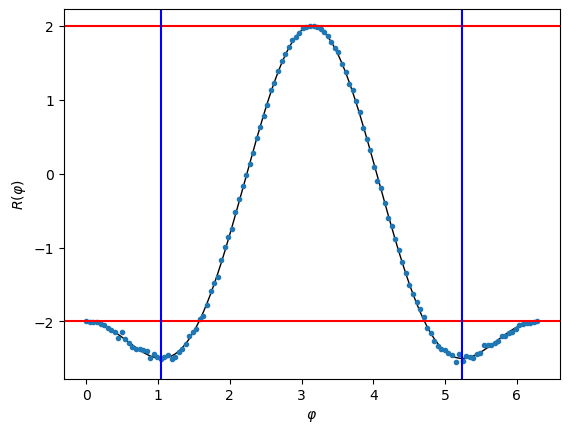

In [5]:
' función analítica '
fx= 1 + 2*np.cos(valphi) - np.cos(2*valphi)
plt.plot(valphi,-fx,'k-',linewidth=1)
' resultado de la simulación'
plt.plot(valphi,R,'.')
plt.axhline(y = 2, color = 'r', linestyle = '-')
plt.axhline(y = -2, color = 'r', linestyle = '-')
' líneas horizotales en +2 y - 2'
plt.axvline(x = np.pi/3, color = 'b', linestyle = '-')
plt.axvline(x = 5*np.pi/3, color = 'b', linestyle = '-')
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$R(\varphi)$')
plt.show()

<a id='sec_Notebooks_Entrelazamiento_2'></a>
## Experimento GHZ   

El estado GHZ es: 
<br>
<br>
$$
\ket{\rm GHZ} = \frac{1}{\sqrt{2}}( \ket{000} - \ket{111} )\, . 
$$

Lo que queremos ver es que verifica los resultados para los valores esperados de las cadenas de Pauli:

$$
\begin{array}{ccc}
{\rm medimos} & & \hbox{obtenemos} ~ x,y ~~ \hbox{tales que} \\
XYY ~~~~~ &\to& ~xyy =~~~ 1\nonumber\\
YXY ~~~~~ &\to& ~yxy =~~~ 1 \label{GHZeq}\\
YYX ~~~~~ &\to& ~yyx =~~~ 1\nonumber\\
XXX ~~~~~ &\to& ~xxx = -1\nonumber
\end{array}
$$


El circuito que genera el estado GHZ es el siguiente:

<figure><center>
<img src="./Figuras/Fig_entrelazamiento_GHZ.png" align=center alt="" width='350px'/>
<center>GHZ</center>
</center></figure>

Inicialicemos el estado GHZ y midamos en las bases correspondientes

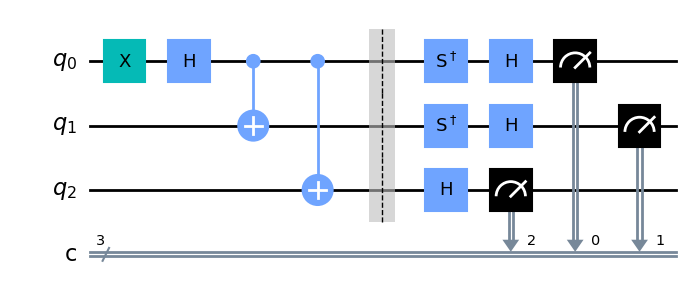

In [6]:
circuit_GHZ = QuantumCircuit(3,3) 

circuit_GHZ.x(0)
circuit_GHZ.h(0)
circuit_GHZ.cx(0,1)
circuit_GHZ.cx(0,2)

#circuit_GHZ.draw(output='mpl')

#########################################
# Elegir uno de los siguientes

#multibasis = 'YYX'
#multibasis = 'YXY'
multibasis = 'XYY'
#multibasis = 'XXX'
#########################################


circuit_GHZ.barrier()
add_Pauli_measurement(circuit_GHZ, multibasis)
circuit_GHZ.draw(output='mpl')

In [7]:
assert(circuit_GHZ.num_qubits == len(multibasis))

In [8]:
# transpilamos
t_circuit_GHZ = transpile(circuit_GHZ, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_GHZ = simulador.run(t_circuit_GHZ, shots = 10000).result()
counts_GHZ = result_GHZ.get_counts()

print('<'+str(multibasis)+'> =', val_esp_sigma(counts_GHZ)[0])

<XYY> = 1.0


Véase que como hemos usado la función `add_Pauli_measurement()` para hacer las medidas en las bases correspondientes, ahora al final hemos podido usar la función `val_esp_sigma()` para calcular el valor esperado como si hubieramos medido en la base $ZZZ$

<a id='sec_Notebooks_Entrelazamiento_3'></a>
## Protocolo de teleportación   

- El estado inicial es
$ \to 
\ket{\phi} \ket{B_{00}} =  \ket{\phi}\otimes \frac{1}{\sqrt{2}}\left(\ket{0}\otimes \ket{0} + \ket{1}\otimes\ket{1}\rule{0mm}{4mm}\right)\, .
$
<br>
<br>
Alice tiene acceso a los dos primeros qubits y Bob al tercero. 

<figure><center>
<img src="./Figuras/Fig_entrelazamiento_teleportacion.png" align=center alt="" width='550px'/>

</center></figure>


- Alice realiza una  <i>medida de Bell</i> a sus dos qubits.

    Ello  implica un desentrelazador $U_{\rm desent}= (H \otimes I)\cdot U_{\rm CNOT}.~$
    Un cálculo sencillo  da el resultado
    
    \begin{eqnarray}
     (H \otimes I\otimes I)(U_{\rm CNOT}\otimes I)\, \ket{\phi}\ket{B_{00}} & =&  \frac{1}{2}
    \left[\rule{0mm}{3mm} \ket{00}(a\ket{0} + b\ket{1}) + \ket{01}(a\ket{1}+ b\ket{0}) \right. \nonumber\\
    \rule{0mm}{14mm}
    &&\left.  \rule{0mm}{3mm}+ ~\ket{10}(a\ket{0}-b\ket{1}) + \ket{11}(a\ket{1}-b\ket{0})\right] \label{teleport}
    \end{eqnarray}


- Alicia mide el estado que obra en su poder, y obtiene un 2-bit  clásico, $xy$ de manera equiprobable para las 4 posibilidades.

    De forma correlacionada, el qúbit de Bob colapsa a uno de los 4 estados $\ket{\varphi_{xy}},~$ pero no sabe a cuál.


- Alice envía el resultado de su medida $xy$ por un canal clásico a Bob

-  Bob efectúa sobre su cúbit, una operación controlada por este 2-bit, $U_{xy} =  X^y Z^x $. 

    $$
    xy ~=~ \left\{ \begin{array}{c} 00 \\ 01 \\ 10 \\ 11 \end{array} \right\}~~ \Longrightarrow  
    ~~~ X^y Z^x \ket{\varphi_{xy}} ~=~ \left\{  \begin{array}{rl}    I :& (a\ket{0} + b\ket{1})  \\    
    X: & (a\ket{1} + b\ket{0})  \\  Z:& (a\ket{0} - b\ket{1})  \\  
    XZ = -iY:&   (a\ket{1} - b\ket{0}) \\
    \end{array} \right. ~~ \longrightarrow  ~~ a \ket{0} + b\ket{1}\,  = \, \ket{\phi}
    $$

    Como resultado de esta operación, el qúbit de Bob es finalmente $\ket{\phi}$.

Vamos preparar el estado de Alice

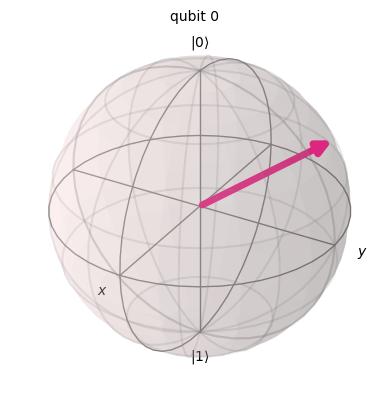

In [9]:
# escoge dos ángulos theta y phi en la esfera de Bloch
[theta,phi]=[1.1 , 2.2]

# o hazlo de forma aleatoria
#import random
#[theta,phi] = np.array([np.pi*np.random.rand(),2*np.pi*np.random.rand()])

estado = [np.cos(theta/2),(np.exp(1j*phi))*np.sin(theta/2)]

#visualicémoslo en la esfera de Bloch
plot_bloch_multivector(estado)

Lo primero que haremos será incializar el circuito, dotado de tres qubits y dos canales clásicos en dos registros. Alice tendrá control sobre los dos primeros $q_0, q_1$ y Bob sobre el tercero $q_2$.

In [10]:
qrA = QuantumRegister(2, name="qAlice") 
qrB = QuantumRegister(1, name="qBob") 
crx = ClassicalRegister(1, name="crx") 
cry = ClassicalRegister(1, name="cry") 

Generamos el circuito de teleportación

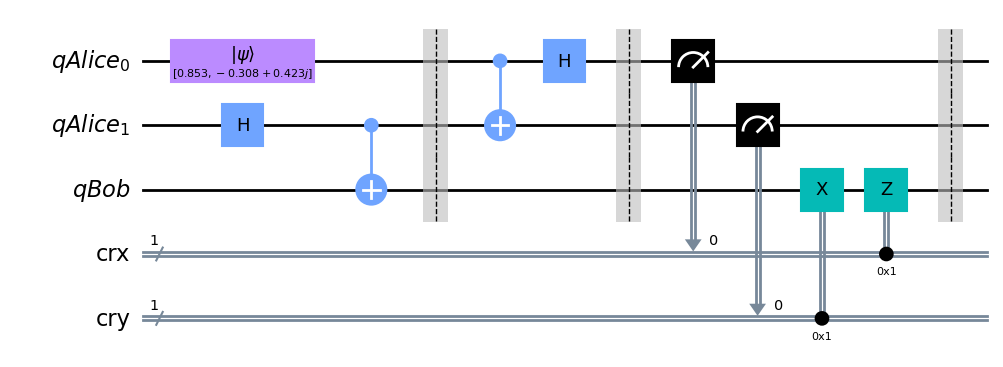

In [11]:
# inicializa el circuito
qc = QuantumCircuit(qrA,qrB, crx, cry)

# prepara el estado de Bell que comparten Alice y Bob
qc.h(qrA[1])
qc.cx(qrA[1],qrB[0])

# inyecta en el circuito el estado a teleportar
qc.initialize(estado,0)

qc.barrier()

# Añade un medidor de estados de Bell en los cúbits de Alice y efectúa las medidas
qc.cx(qrA[0],qrA[1])
qc.h(qrA[0])
qc.barrier()
qc.measure([qrA[0],qrA[1]],[0,1])

# Añade el operador X^y Z^x controlado clásicamente por las salidas x e y 
qc.x(qrB[0]).c_if(cry, 1)  
qc.z(qrB[0]).c_if(crx, 1)  
qc.barrier()

#visualiza el circuito 
qc.draw('mpl')

In [12]:
# transpilamos
t_qc = transpile(qc, backend = simulador)

# Ejecutamos la simulación con 1000 shots 
result_qc = simulador.run(t_qc, shots = 10000).result()
counts_qc = result_qc.get_counts()
counts_qc

{'1 1': 2548, '1 0': 2506, '0 0': 2487, '0 1': 2459}

Observa al ejecutar repetidas veces que los resultados de las medidas intermedias son aleatorios, pero el estado teleportado es siempre el correcto